In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import pickle

In [2]:
# Load the data from a pickle file
with open('data/test.pickle', 'rb') as f:
    test = pickle.load(f)

# Load the data from a pickle file
with open('data/train.pickle', 'rb') as f:
    train = pickle.load(f)

In [3]:
train = train.dropna()
y_train = train['seizure']
X_train = train.drop(columns = 'seizure')

test = test.dropna()
y_test = test['seizure']
X_test = test.drop(columns = 'seizure')

In [4]:
def metrics(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    dict = {"metric":['sensitivity','specificity','accuracy'], 'precision':[f'{(tp/(tp+fn))*100:.3f}%', f'{(tn/(fp+tn))*100:.3f}%', f'{((tp+tn)/(tn+fp+fn+tp))*100:.3f}%']}
    return pd.DataFrame.from_dict(dict).style.hide(axis="index")

# ML

## K Neighbors

In [66]:
clf=KNeighborsClassifier(n_neighbors=60, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [67]:
metrics(y_test, y_pred)

metric,precision
sensitivity,88.337%
specificity,89.056%
accuracy,88.698%


## SVG

In [31]:
clf=SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [32]:
metrics(y_test, y_pred)

metric,precision
sensitivity,86.393%
specificity,87.768%
accuracy,87.083%


## Random forest

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'sensitivity: {(tp/(tp+fn))*100:.3f}%')
print(f'specificity: {(tn/(fp+tn))*100:.3f}%')
print(f'accuracy: {((tp+tn)/(tn+fp+fn+tp))*100:.3f}%')

sensitivity: 86.825%
specificity: 91.845%
accuracy: 89.343%


In [4]:
clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [28]:
metrics(y_test, y_pred)

metric,precision
sensitivity,86.825%
specificity,91.845%
accuracy,89.343%


In [8]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'sensitivity: {(tp/(tp+fn))*100:.3f}%')
print(f'specificity: {(tn/(fp+tn))*100:.3f}%')
print(f'accuracy: {((tp+tn)/(tn+fp+fn+tp))*100:.3f}%')

sensitivity: 86.825%
specificity: 91.845%
accuracy: 89.343%


# DL

## FF Neural Network

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

c:\Users\Eugene Chen\.conda\envs\mne\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### parse dataset to tensors

In [5]:
train = train.dropna()
y_train = train['seizure']
X_train = train.drop(columns = 'seizure')

test = test.dropna()
y_test = test['seizure']
X_test = test.drop(columns = 'seizure')

#### data loader

In [6]:
class SeizureData(torch.utils.data.Dataset):
    def __init__(self, x_val, y_val):

        self.y_data = torch.tensor(y_val.values.astype(np.float32), requires_grad=False)
        self.x_data = torch.tensor(x_val.values.astype(np.float32), requires_grad=True)
        self.n_samples = self.x_data.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


In [7]:
dataset = SeizureData(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=50,
                          shuffle=True,
                          drop_last=True)
dataset = SeizureData(X_test, y_test)
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=50,
                          shuffle=True,
                          drop_last=True)

### Model

In [36]:
input_size = X_train.shape[1]
output_size = 1

class FFNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FFNN, self).__init__()
        # define layers
        self.lin1 = nn.Linear(input_dim, 64)
        self.norm1 = nn.BatchNorm1d(64)
        self.lrelu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.3)

        self.lin2 = nn.Linear(64, 16)
        self.norm2 = nn.BatchNorm1d(16)
        self.lout = nn.Linear(16, output_dim)

    def forward(self, x):
        y_pred = self.lin1(x)
        y_pred = self.norm1(y_pred)
        y_pred = self.lrelu(y_pred)
        y_pred = self.drop(y_pred)

        y_pred = self.lin2(y_pred)
        y_pred = self.norm2(y_pred)
        y_pred = self.lrelu(y_pred)
        
        y_pred = self.lout(y_pred)
        return y_pred.squeeze()

model = FFNN(input_size, output_size)
print(model)

FFNN(
  (lin1): Linear(in_features=153, out_features=64, bias=True)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (drop): Dropout(p=0.2, inplace=False)
  (lin2): Linear(in_features=64, out_features=16, bias=True)
  (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lout): Linear(in_features=16, out_features=1, bias=True)
)


#### loss and optimization

In [37]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
def accuracy(ys, ts):
    ys = ys > 0.5
    correct_prediction = torch.eq(ys, ts)
    m = torch.mean(correct_prediction.float())
    return m

#### training

In [38]:
num_epochs = 30
num_total_steps = len(train_loader)

# Initialize lists for training and validation
train_iter, valid_iter = [], []
train_loss, train_accs = [], []
valid_loss, valid_accs = [], []

# Train the model
iter_num = 0
for epoch in range(num_epochs):

    with torch.no_grad():
        val_losses, val_accs, val_lengths = 0, 0, 0
        for valid_input,valid_label in test_loader:
            outputs = model(valid_input)
            predicted = (outputs>0.5).float()
            val_losses += criterion(outputs, valid_label)
            val_accs += ((predicted == valid_label).sum().item())/valid_label.size(0)
            val_lengths += 1
        valid_accs.append(val_accs / val_lengths)
        valid_loss.append(val_losses / val_lengths)
        valid_iter.append(iter_num)

    for i, (input,label) in enumerate(train_loader):
        
        #forward
        output = model(input)
        loss = criterion(output, label)
        #plot
        train_accs.append(float(accuracy(output, label).data.numpy()))
        train_loss.append(float(loss.data.numpy()))
        train_iter.append(iter_num)
        iter_num += 1
        #backward 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_iter, train_loss, label='train_loss')
    plt.plot(valid_iter, valid_loss, label='valid_loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_iter, train_accs, label='train_accs')
    plt.plot(valid_iter, valid_accs, label='valid_accs')
    plt.legend()
    plt.show()
    print(f"Train, it: {epoch} loss: {train_loss[-1]:.2f} accuracy: {train_accs[-1]:.2f}")
    print(f"Valid, it: {epoch} loss: {valid_loss[-1]:.2f} accuracy: {valid_accs[-1]:.2f}")
    clear_output(wait=True)


KeyboardInterrupt: 

#### testing

In [104]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for input, labels in test_loader:
        outputs = model(input)
        loss = criterion(outputs, labels)
        # max returns (value ,index)
        predicted = (outputs>0.5).float()
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the {loss} test is : {acc} %')

Accuracy of the network on the 122.23466491699219 test is : 78.55555555555556 %


In [49]:
# Test the model
with torch.no_grad():
    all_predicted = torch.tensor([])
    all_label = torch.tensor([])
    for input, labels in test_loader:
        outputs = model(input)
        # max returns (value ,index)
        all_predicted = torch.cat([all_predicted, (outputs>0.5).float()])
        all_label = torch.cat([all_label, labels])
metrics(all_predicted, all_label)
    

metric,precision
sensitivity,94.118%
specificity,68.062%
accuracy,75.444%


### accuracy

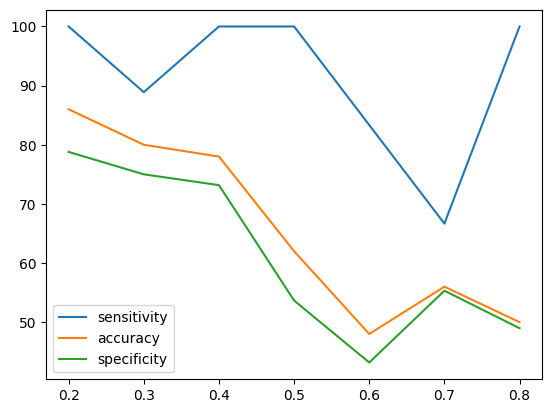

metric,precision
sensitivity,100.000%
specificity,48.980%
accuracy,50.000%


In [30]:
step = 0.1
threshold = np.arange(0.2, 0.8+step, step)
data = np.array([])
sensitivity = []
specificity = []
accuracy = []
for t in threshold:
    with torch.no_grad():
        for input, labels in test_loader:
            ttn, tfp, tfn, ttp = 0,0,0,0
            outputs = model(input)
            data = np.append(data, output)
            predicted = (outputs>t).float()
            tn, fp, fn, tp = confusion_matrix(predicted, labels, labels=[0, 1] ).ravel()
            ttn += tn
            tfp += fp
            tfn += fn
            ttp += tp
        if (ttp+tfn) == 0:
            sensitivity.append(0)
        else:
            sensitivity.append((ttp/(ttp+tfn))*100)
        if tfp+ttn == 0:
            specificity.append(0)
        else:
            specificity.append((ttn/(tfp+ttn))*100)
        accuracy.append(((ttp+ttn)/(ttn+tfp+tfn+ttp))*100)

plt.plot(threshold, sensitivity, label='sensitivity')
plt.plot(threshold, accuracy, label='accuracy')
plt.plot(threshold, specificity, label='specificity')
plt.legend()
plt.show()

dict = {"metric":['sensitivity','specificity','accuracy'], 'precision':[f'{(tp/(tp+fn))*100:.3f}%', f'{(tn/(fp+tn))*100:.3f}%', f'{((tp+tn)/(tn+fp+fn+tp))*100:.3f}%']}

pd.DataFrame.from_dict(dict).style.hide(axis="index")

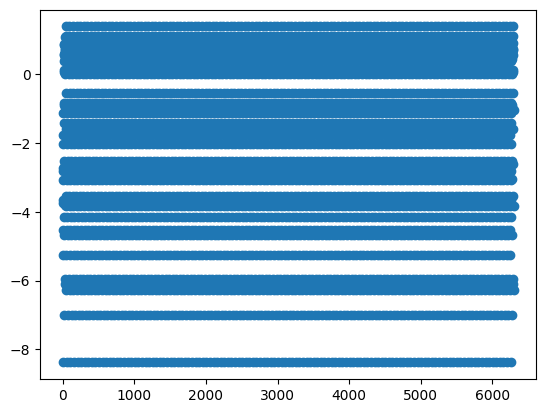

In [51]:
x = list(range(len(data)))
plt.scatter(x, data)


In [35]:
torch.save(model,'model07-12-2022.pt')

In [62]:
model = torch.load('model07-12-2022.pt')

In [37]:
model.eval()

FFNN(
  (lin1): Linear(in_features=153, out_features=50, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lin2): Linear(in_features=50, out_features=50, bias=True)
  (lout): Linear(in_features=50, out_features=1, bias=True)
)